# Feature Engineering and Machine Learning Modeling

## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline
sns.set(color_codes=True)

## Loading the Data

In [2]:
df = pd.read_csv('bcgdata.csv')

In [3]:
df["date_activ"] = pd.to_datetime(df["date_activ"], infer_datetime_format=True, errors='coerce')
df["date_end"] = pd.to_datetime(df["date_end"], infer_datetime_format=True, errors='coerce')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], infer_datetime_format=True, errors='coerce')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], infer_datetime_format=True, errors='coerce')

In [4]:
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-01-11,2015-06-23,0.00,...,0.000131,4.100000e-05,9.084740e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,NaT,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,NaT,2015-04-17,47.96,...,0.000004,9.450000e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450000e-08,0.000000e+00,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,NaT,2015-03-31,240.04,...,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,NaT,2015-03-09,445.75,...,0.000011,2.900000e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.900000e-06,4.860000e-10,0


In [5]:
price_df = pd.read_csv("D:\datasets\pricedata.csv")
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


## Commencing Feature Engineering

In [6]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [7]:
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-01-11,2015-06-23,0.00,...,9.084740e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,NaT,2015-08-31,189.95,...,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,NaT,2015-04-17,47.96,...,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450000e-08,0.000000e+00,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,NaT,2015-03-31,240.04,...,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,NaT,2015-03-09,445.75,...,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.900000e-06,4.860000e-10,0,-0.006192,0.162916


### Average Price Changes

In [8]:
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [9]:
# Calculating the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [10]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-01-11,2015-06-23,0.00,...,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,NaT,2015-08-31,189.95,...,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,NaT,2015-04-17,47.96,...,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,NaT,2015-03-31,240.04,...,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,NaT,2015-03-09,445.75,...,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


### Maximum Price Changes

In [11]:
# Aggregating average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [12]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [13]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [14]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-01-11,2015-06-23,0.00,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,NaT,2015-08-31,189.95,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,NaT,2015-04-17,47.96,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,NaT,2015-03-31,240.04,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,NaT,2015-03-09,445.75,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


In [15]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
tenure,
3,0.143713
2,0.133080
4,0.125756
13,0.095238
5,0.085425
12,0.083333
6,0.080713
7,0.073394
11,0.063584


In [16]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [17]:
def convert_months(reference_date, df, date_column):
    """
    Calculates the difference in months between a reference date and dates in a column,
    handling missing values (NaN) and edge cases.

    Args:
        reference_date (pandas.Timestamp): The reference date.
        df (pandas.DataFrame): The DataFrame containing the date column.
        date_column (str): The name of the date column.

    Returns:
        pandas.Series: A Series containing the difference in months for each date,
                       with appropriate handling of missing values.
    """

    # Ensure date format
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')  # Handle potential errors

    # Calculate timedelta in days (assuming whole months needed)
    days_delta = (reference_date - df[date_column]).dt.days

    # Handle missing values (replace with a placeholder or function depending on your needs)
    months_delta = days_delta.fillna(-999)  # Replace with -999 (or a suitable function)

    # Convert to integer and return, handling potential edge cases (e.g., negative values)
    months_delta = months_delta.clip(lower=0)  # Ensure non-negative months
    return months_delta.astype(int)

# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [18]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0,1.78,0.114481,...,0.085483,0.146033,44.266930,8.145775,44.26693,3,930,0,355,192
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0,16.27,0.145711,...,0.085483,0.151367,44.444710,0.000000,44.44471,7,2324,0,0,123
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0,38.72,0.165794,...,0.089162,0.172468,44.444710,0.000000,44.44471,6,2086,0,0,259
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0,19.83,0.146694,...,0.000000,0.153133,44.444710,0.000000,44.44471,6,2103,0,0,276
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0,131.73,0.116900,...,0.033743,0.055866,16.291555,8.145775,24.43733,6,2179,0,0,298


### Transforming Boolean Data

In [19]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100544
1,0.081856


This shows that customers who do not buy gas are almost 2% more likely to churn than customers who also buy gas from PowerCo.

### Tending to Categorical Data and Numerical Data

In [20]:
# Transform channel_sales into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [21]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0,1.78,0.114481,0.098142,...,3,930,0,355,192,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0,16.27,0.145711,0.000000,...,7,2324,0,0,123,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0,38.72,0.165794,0.087899,...,6,2086,0,0,259,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0,19.83,0.146694,0.000000,...,6,2103,0,0,276,0,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0,131.73,0.116900,0.100015,...,6,2179,0,0,298,1,0,0,0,0


In [22]:
# Transform origin_up into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [23]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0,1.78,0.114481,0.098142,...,355,192,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0,16.27,0.145711,0.000000,...,0,123,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0,38.72,0.165794,0.087899,...,0,259,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0,19.83,0.146694,0.000000,...,0,276,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0,131.73,0.116900,0.100015,...,0,298,1,0,0,0,0,1,0,0


In [24]:
# statistics of the skewed features
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


In [25]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [26]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,4.223939,0.779244,2.264646,2.962177,1.784610,0.966726,1.517203,0.137283,0.050491,43.130056
std,0.884515,1.717071,1.769305,0.683592,1.584986,5.108289,0.571481,0.024623,0.049037,4.485988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754023,0.000000,0.000000,2.695477,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149727,0.000000,2.899547,3.046836,2.498311,0.000000,1.296555,0.143166,0.084138,44.311378
75%,4.610285,0.000000,3.529430,3.380716,3.242231,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


The Standard Deviations are now much lower after the transformation and the skewness is reduced.

In [27]:
df[skewed].head(10)

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
0,0.000000,4.739944,0.000000,0.000000,0.000000,0,0.444045,0.114481,0.098142,40.606701
1,3.668479,0.000000,0.000000,2.280920,0.000000,0,1.237292,0.145711,0.000000,44.311378
2,2.736397,0.000000,0.000000,1.689841,0.000000,0,1.599009,0.165794,0.087899,44.311378
3,3.200029,0.000000,0.000000,2.382089,0.000000,0,1.318689,0.146694,0.000000,44.311378
4,3.646011,0.000000,2.721811,2.650065,2.721811,0,2.122969,0.116900,0.100015,40.606701
5,3.919235,0.000000,3.300813,2.901970,3.300813,0,1.493040,0.164775,0.086131,45.308378
6,4.654157,0.000000,0.000000,3.906889,0.000000,0,0.000000,0.166178,0.087538,44.311378
7,4.470602,0.000000,3.100715,2.937382,2.876218,0,2.162833,0.115174,0.098837,40.606701
8,3.471732,0.000000,0.000000,2.648731,0.000000,0,1.226600,0.145711,0.000000,44.311378
9,4.416058,0.000000,3.340246,3.437608,3.340246,0,2.118695,0.115761,0.099419,40.606701


In [28]:
df[skewed].shape

(14606, 10)

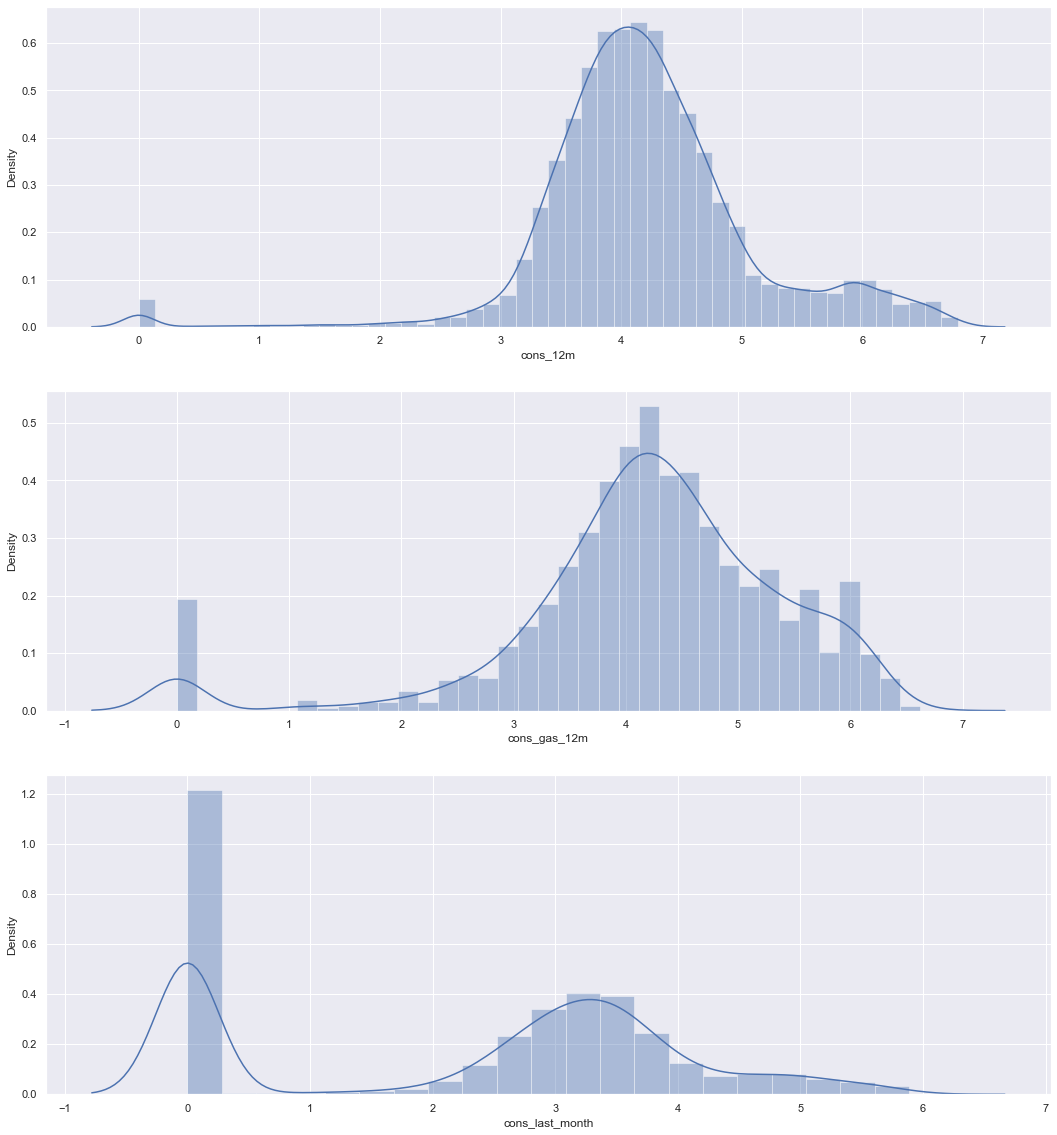

In [29]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

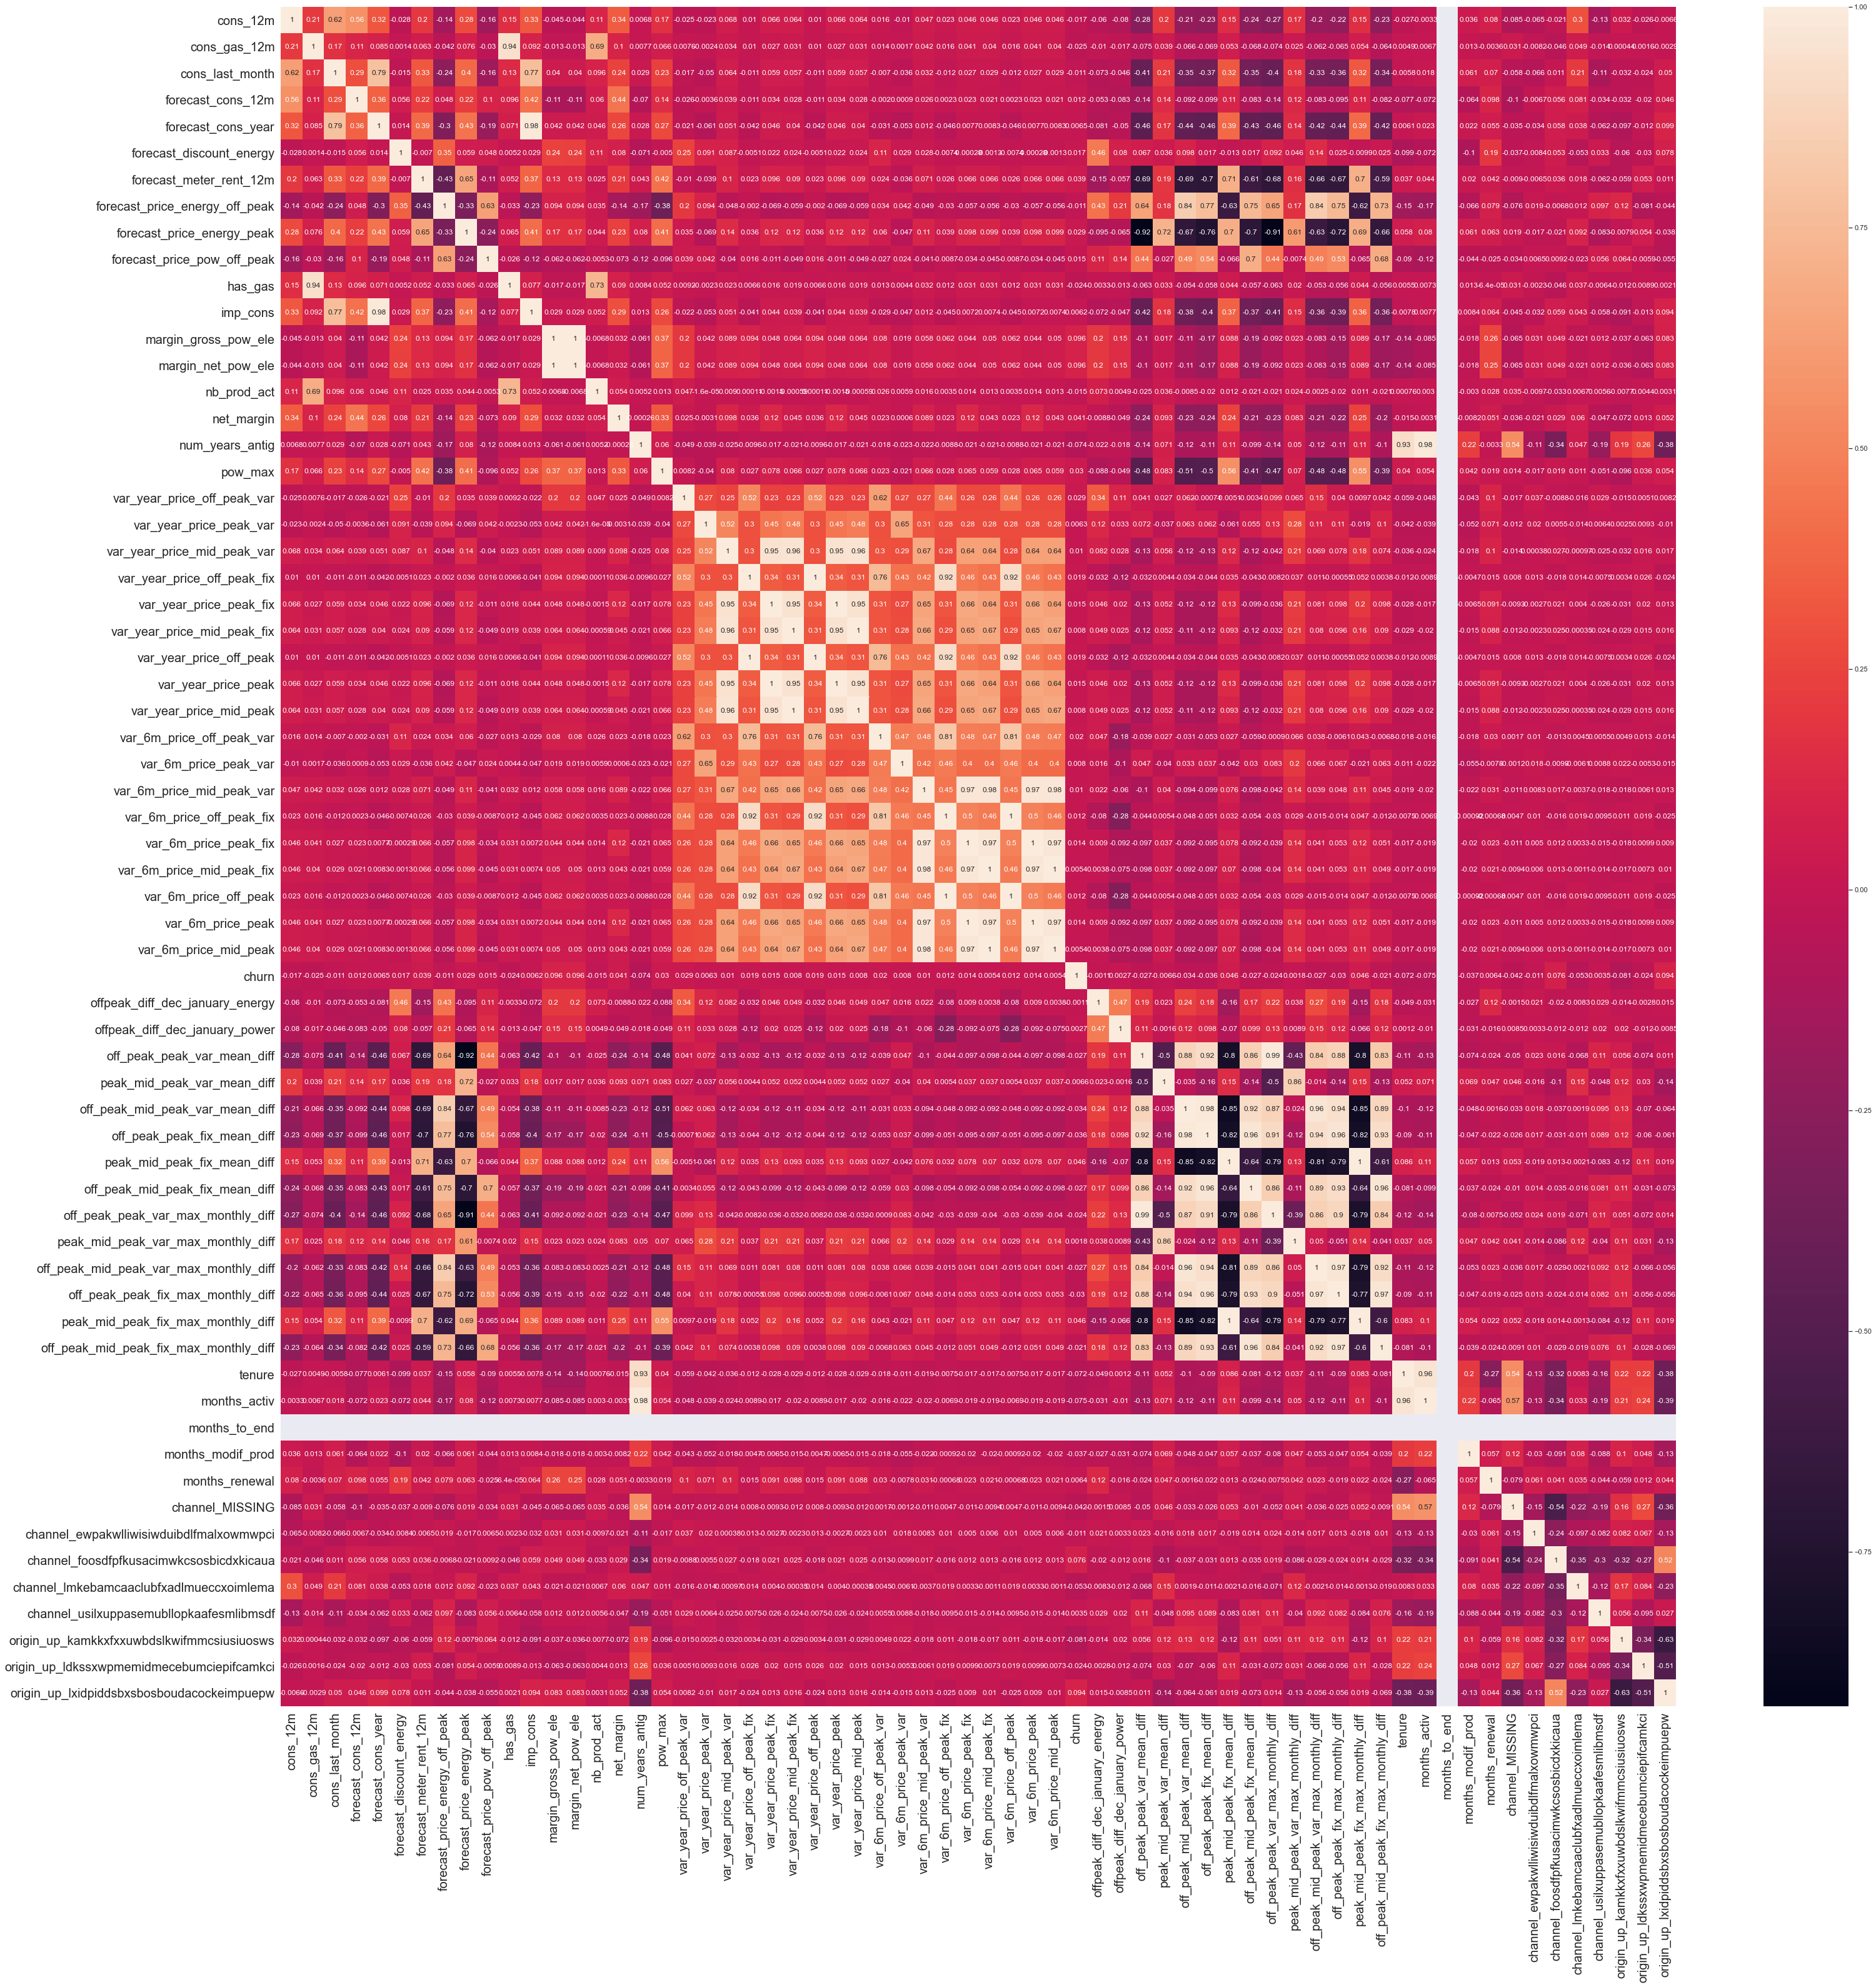

In [30]:
correlation = df.corr()
# Plot correlation
plt.figure(figsize=(50, 50))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

#### Removing certain Variables that exhibit high correlation with other independent variables

In [31]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year', 'forecast_meter_rent_12m', 'forecast_price_energy_peak'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_price_energy_off_peak,forecast_price_pow_off_peak,has_gas,imp_cons,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0,0.114481,40.606701,1,0.00000,...,355,192,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0,0.145711,44.311378,0,0.00000,...,0,123,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0,0.165794,44.311378,0,0.00000,...,0,259,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0,0.146694,44.311378,0,0.00000,...,0,276,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0,0.116900,40.606701,0,1.72689,...,0,298,1,0,0,0,0,1,0,0


## Machine Learning Modeling

### Random Forest Classifier

In [32]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [33]:
# Making another copy of the original data
train_df = df.copy()

# Separating the target variable from the independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 59)
(14606,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 59)
(10954,)
(3652, 59)
(3652,)


In [35]:
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [36]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [37]:
y_test.value_counts()

0    3286
1     366
Name: churn, dtype: int64

In [38]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 19
False positives: 5
True negatives: 3281
False negatives: 347

Accuracy: 0.9036144578313253
Precision: 0.7916666666666666
Recall: 0.05191256830601093


In [39]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

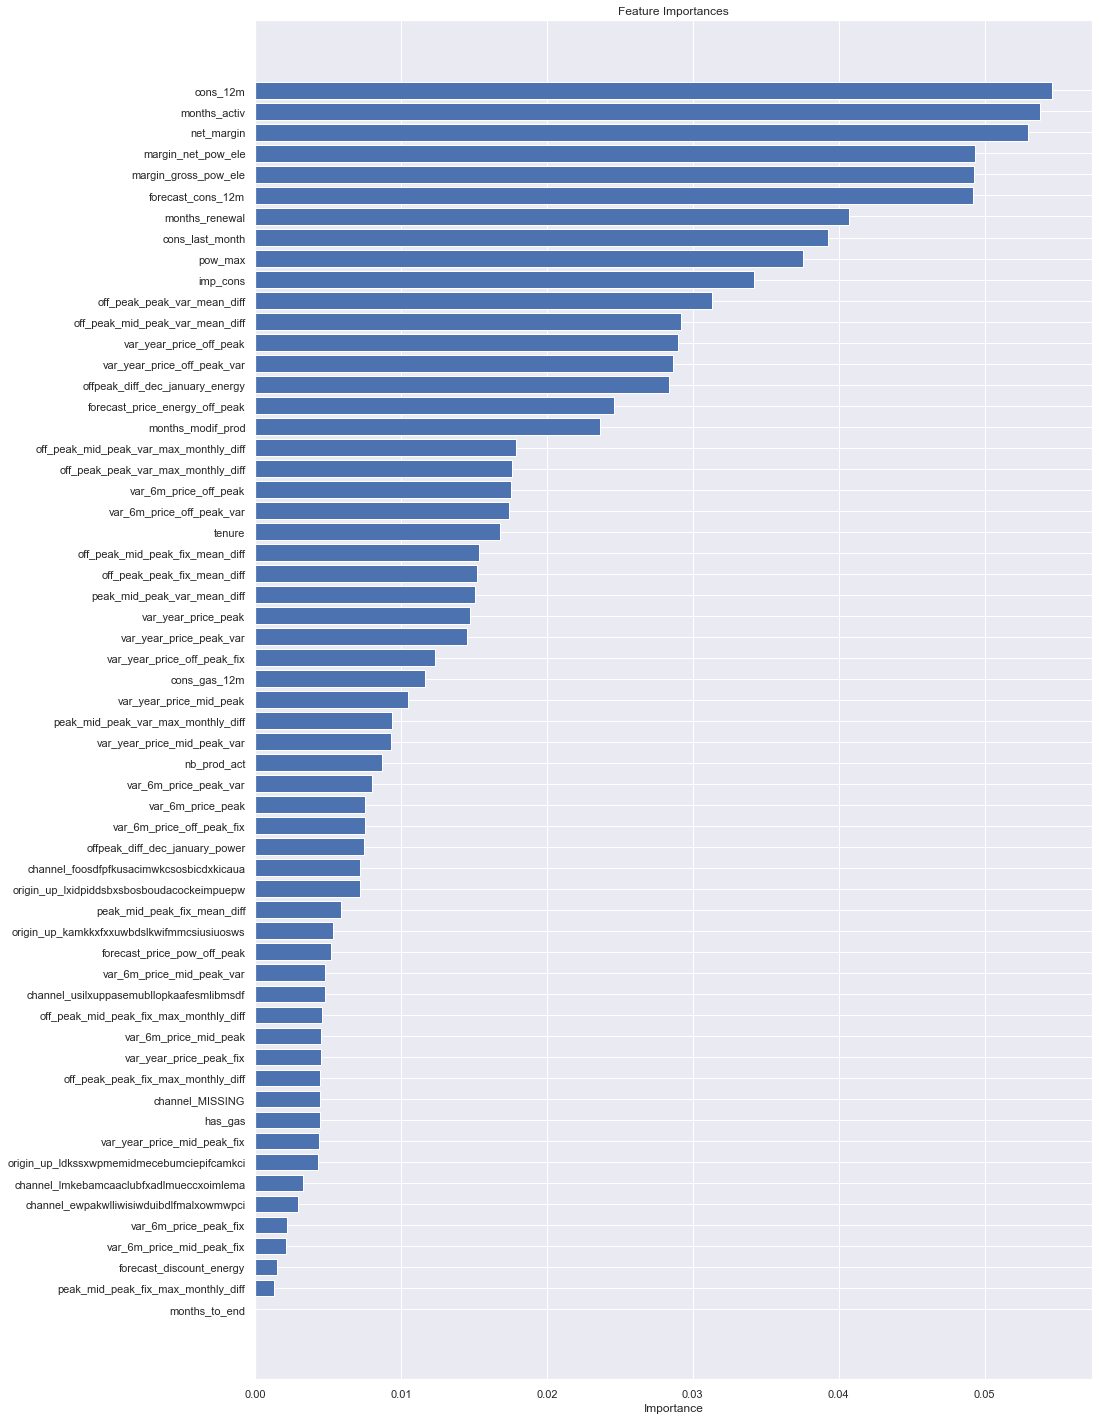

In [40]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

Through the above graph, we can see that the most important features are:
1. Consumption over 12 months
2. Net margin
3. Net Margin on Power Subscription

Consumption over 12 months and Net Margin are top drivers of churn according to this model.